# Machine Translation

German-English

# 1)- Importing key modules

In [1]:
import string 
import re 
from numpy import array, argmax, random, take 
import pandas as pd 
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint 
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model 
from keras import optimizers 
import matplotlib.pyplot as plt 
% matplotlib inline 
pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.


# 2)- Reading Dataset

In [0]:
# function to read raw text file
def read_text(filename): 
        # open the file 
        file = open(filename, mode='rt', encoding='utf-8') 
        
        # read all text 
        text = file.read() 
        file.close() 
        return text

In [0]:
# split text into sentences 
def to_lines(text): 
      sents = text.strip().split('\n') 
      sents = [i.split('\t') for i in sents] 
      return sents

In [0]:
data = read_text("deu.txt") 
deu_eng = to_lines(data) 
deu_eng = array(deu_eng)

In [0]:
deu_eng = deu_eng[:50000,:]

# 3)-Text Pre-Processing

In [6]:
deu_eng

array([['Hi.', 'Hallo!'],
       ['Hi.', 'Grüß Gott!'],
       ['Run!', 'Lauf!'],
       ...,
       ['The man died of cancer.', 'Der Mann starb an Krebs.'],
       ['The man lay motionless.', 'Der Mann lag bewegungslos da.'],
       ['The man must be insane.', 'Der Mann muss geistesgestört sein.']],
      dtype='<U537')

In [7]:
# for english part 
deu_eng[:,0]

array(['Hi.', 'Hi.', 'Run!', ..., 'The man died of cancer.',
       'The man lay motionless.', 'The man must be insane.'],
      dtype='<U537')

In [8]:
# for german part of lang.
deu_eng[:,1]

array(['Hallo!', 'Grüß Gott!', 'Lauf!', ..., 'Der Mann starb an Krebs.',
       'Der Mann lag bewegungslos da.',
       'Der Mann muss geistesgestört sein.'], dtype='<U537')

### 3.1)-Text cleaning

In [0]:
# Remove punctuation 
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]] 
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]] 

# convert text to lowercase 
for i in range(len(deu_eng)): 
    deu_eng[i,0] = deu_eng[i,0].lower() 
    deu_eng[i,1] = deu_eng[i,1].lower()

### 3.2)-Text to Sequence Conversion

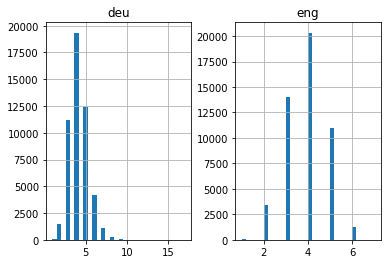

In [10]:
# empty lists 
eng_l = [] 
deu_l = [] 

# populate the lists with sentence lengths 
for i in deu_eng[:,0]: 
      eng_l.append(len(i.split())) 

for i in deu_eng[:,1]: 
      deu_l.append(len(i.split())) 

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})
length_df.hist(bins = 30) 
plt.show()

### 3.3)-vectorize our text data 

by using Keras’s Tokenizer()

In [11]:
# function to build a tokenizer 
def tokenization(lines): 
      tokenizer = Tokenizer() 
      tokenizer.fit_on_texts(lines) 
      return tokenizer

# prepare english tokenizer 
eng_tokenizer = tokenization(deu_eng[:, 0]) 
eng_vocab_size = len(eng_tokenizer.word_index) + 1 
eng_length = 8 

print('English Vocabulary Size: %d' % eng_vocab_size)





English Vocabulary Size: 6352


In [12]:
# prepare Deutch tokenizer 
deu_tokenizer = tokenization(deu_eng[:, 1]) 
deu_vocab_size = len(deu_tokenizer.word_index) + 1 
deu_length = 8 
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10678


In [0]:
# encode and pad sequences 
def encode_sequences(tokenizer, length, lines):          
         # integer encode sequences          
         seq = tokenizer.texts_to_sequences(lines)          
         # pad sequences with 0 values          
         seq = pad_sequences(seq, maxlen=length, padding='post')           
         return seq

# 4)-Model Building

### 4.1)- Train-test Split

In [0]:
from sklearn.model_selection import train_test_split 

# split data into train and test set 
train,test= train_test_split(deu_eng,test_size=0.2,random_state= 12)

### 4.2)- Defining input and target
We will encode German sentences as the input sequences and English sentences as the target sequences

In [0]:
# prepare training data 
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1]) 
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0]) 

# prepare validation data 
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1]) 
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

### 4.3)- build NMT model

In [0]:
 def build_model(in_vocab,out_vocab, in_timesteps,out_timesteps,n):   
      model = Sequential() 
      model.add(Embedding(in_vocab, n, input_length=in_timesteps,   
      mask_zero=True)) 
      model.add(LSTM(n)) 
      model.add(RepeatVector(out_timesteps)) 
      model.add(LSTM(n, return_sequences=True))  
      model.add(Dense(out_vocab, activation='softmax')) 
      return model

In [17]:
# model compilation (with 512 hidden units)
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

rms = optimizers.RMSprop(lr=0.001) 
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [18]:
filename = 'model.h1.24_jan_19' 

# set checkpoint
checkpoint = ModelCheckpoint(filename, monitor='val_loss',  
                             verbose=1, save_best_only=True, 
                             mode='min') 


# train model 
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
                    epochs=30, batch_size=512, validation_split = 0.2, 
                    callbacks=[checkpoint], verbose=1)


Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 13s 404us/step - loss: 3.5509 - val_loss: 3.0272

Epoch 00001: val_loss improved from inf to 3.02724, saving model to model.h1.24_jan_19
Epoch 2/30
32000/32000 [==============================] - 7s 231us/step - loss: 2.8977 - val_loss: 2.8670

Epoch 00002: val_loss improved from 3.02724 to 2.86699, saving model to model.h1.24_jan_19
Epoch 3/30
32000/32000 [==============================] - 7s 233us/step - loss: 2.7222 - val_loss: 2.7533

Epoch 00003: val_loss improved from 2.86699 to 2.75331, saving model to model.h1.24_jan_19
Epoch 4/30
32000/32000 [==============================] - 8s 234us/step - loss: 2.5472 - val_loss: 2.5591

Epoch 00004: val_loss improved from 2.75331 to 2.55912, saving model to model.h1.24_jan_19
Epoch 5/30
32000/32000 [==============================] - 8s 237us/step - loss: 2.3915 - val_loss: 2.4203

Epoch 00005: val_loss improved from 2.55912 to 2.42031

# 5)-Plotting results

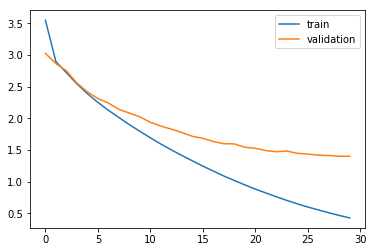

In [20]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.legend(['train','validation']) 
plt.show()

As you can see in the above plot, the validation loss stopped decreasing after 20 epochs.

# 6)-Make Predictions

In [0]:
model = load_model('model.h1.24_jan_19') 

preds = model.predict_classes(testX.reshape((testX.shape[0], testX.shape[1])))

These predictions are sequences of integers. We need to convert these integers to their corresponding words.

### 6.1)- Convert integers to words

In [0]:
def get_word(n, tokenizer):  
      for word, index in tokenizer.word_index.items():                       
          if index == n: 
              return word 
      return None

### 6.2)-Convert predictions into text (English)

In [0]:
preds_text = [] 
for i in preds:        
       temp = []        
       for j in range(len(i)):             
            t = get_word(i[j], eng_tokenizer)             
            if j > 0:                 
                if (t==get_word(i[j-1],eng_tokenizer))or(t== None):                       
                     temp.append('')                 
                else:                      
                     temp.append(t)             
            else:                    
                if(t == None):                                   
                     temp.append('')                    
                else:                           
                     temp.append(t)        
       preds_text.append(' '.join(temp))

In [0]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [26]:
# 1st 15 rows
pred_df.head(15)

,actual,predicted
0,he wanted to be rich,he wanted to be rich
1,i love tom,i love tom
2,let us go home,lets go home
3,i love driving,i love to my
4,this is my dictionary,thats my dictionary
5,hi tom good morning,tom good
6,why is she so popular,why is it so popular
7,ill show you my room,ill show you my room
8,did tom oversleep,tom
9,keep up the good work,look good


In [25]:
# print 15 rows randomly 
pred_df.sample(15)

,actual,predicted
8824,whos your uncle,whos is your
8408,where are we,where are we
8978,im happy youre happy,im glad tom happy
4499,hes wasted,he is aggressive
5279,tom is better,tom is better
3480,please give me one,give me a reason
1951,my conscience is clear,i changed sunglasses
255,black suits you,the suits is
3430,tom is on the roof,tom is on the
2644,tom has to be hot,tom must be
